In [1]:
%matplotlib notebook
%pylab
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


## Представление считывателя и метки

Считыватель - активное устройство, описывается классом NodeA. Метки - пассивные устройство, для их описания будем использовать класс NodeB.

In [2]:
#
# Different radiation antenna patterns. We consider only symmetric antenna 
# radiation patterns so each pattern is a function of a single angle between
# antenna normal and direction.
#
isotropic_radiation_pattern = lambda a: 1.0
dipole_radiation_pattern = lambda a: np.abs(cos(pi * sin(a)) / cos(a))

#
# Reflection koefficients. Each reflection koefficient depends on the material
# the reflecting ray meets. In basic case, reflection is constant, so all the
# energy fell is reflected.
#
constant_reflection = lambda a: 1.0

#
# Node is a base class for both active nodes (NodeA, reader) and passive nodes (NodeP, tags).
# Each node is specified with its height from the ground, antenna gain, angle between
# vertical and antenna normal and radiation pattern.
#
class Node(object):
    def __init__(self, height, angle, gain, radiation_pattern = None):
        self.height = height
        self.angle = angle
        self.__gain = gain
        self.radiation_pattern = radiation_pattern
        
    def isisotropic(self):
        return self.radiation_pattern is None or self.radiation_pattern == isotropic_radiation_pattern
        
    def G(self, theta):
        if self.isisotropic():
            return 1.0
        else:
            return self.radiation_pattern(self.angle - theta)
        
    def gain(self):
        return 0.0 if self.isisotropic() else self.__gain

#
# NodeA is an active node. It additionally to Node's parameters has tx_power which is 
# a power at antenna wires, typically - 28-31.5dbm. All power values are given in dbm.
#
class NodeA(Node):
    def __init__(self, height, angle, gain, radiation_pattern, tx_power):
        super().__init__(height, angle, gain, radiation_pattern)
        self.tx_power = tx_power

#
# NodeP is a passive node. It additionally to Node's parameters has polarization loss (in dbm)
# and modulation loss (also in dbm).
#
class NodeP(Node):
    def __init__(self, height, angle, gain, radiation_pattern, m = 1, 
                 polarization_loss = 0.0, modulation_loss = 6.0):
        super().__init__(height, angle, gain, radiation_pattern)
        self.m = m
        self.polarization_loss = polarization_loss
        self.modulation_loss = modulation_loss = modulation_loss        

#
# Environment describes the wireless medium and environment.
#
class Env(object):
    def __init__(self, distance, frequency,
                 ground_reflection = constant_reflection, 
                 ceil_reflection = constant_reflection,
                 noise = -120,
                 c = 2.99792458 * 10e8):
        self.distance = distance
        self.frequency = frequency
        self.noise = noise
        self.ground_reflection = ground_reflection
        self.ceil_reflection = ceil_reflection
        self.c = c        
        
    def get_wave_length(self):
        return self.c / self.frequency
    
    def gr(self, theta):
        return self.ground_reflection(theta)
    
    def gc(self, theta):
        return self.ceil_reflection(theta)

#
# Units conversion functions.
#
w2db = lambda w: 10.0 * log10(w)
w2dbm = lambda w: 30.0 + w2db(w)
dbm2w = lambda dbm: 10 ** ((dbm - 30.0) / 10.0)
db2k = lambda db: 10 ** (db / 10)

Создадим стандартные считыватели и метки, которые будут использоваться нами в дальнейшем:

- считыватель с изотропной антенной (isotropic_reader)
- считыватель c дипольной антенной (dipole_reader)
- метка с изотропной антенной (isotropic_tag)
- метка с дипольной антенной (dipole_tag)

Высота по умолчанию будт приблизительно соответствовать размещению считывателей в точках регистрации транспорта (5м) и меток в номерах машин (0.5м).

In [3]:
isotropic_reader = NodeA(5, pi/3, 8, isotropic_radiation_pattern, 31.5)
dipole_reader = NodeA(5, pi/3, 8, dipole_radiation_pattern, 31.5)
isotropic_tag = NodeP(0.5, pi/2, 2, isotropic_radiation_pattern)
dipole_tag = NodeP(0.5, pi/2, 2, dipole_radiation_pattern)

env = Env(20, 860*10e6, constant_reflection, constant_reflection, noise=-57)

### Вычисление затухания

Для вычисления затухания мы используем три модели:

- FSPL (Free-Space Path Loss)
- двухлучевая модель (один отраженный от земли луч)
- трехлучевая модель (отраженный от земли и от опоры луч)

Трехлучевая модель используется для того, чтобы смоделировать работу системы под мостом или путепроводом.

In [4]:
ox = arange(0.2, env.distance, 0.1)

#
# Two-ray path loss
#
def PL1(distance, node_a, node_p, env):
    d0 = sqrt((node_a.height - node_p.height) ** 2 + distance ** 2)
    a0 = arctan(distance / (node_a.height - node_p.height))
    g0 = node_a.G(a0) * node_p.G(a0)
    K = env.get_wave_length() / (4*pi)
    return (K*g0/d0)**2
    
    
def PL2(distance, node_a, node_p, env):
    d0 = sqrt((node_a.height - node_p.height) ** 2 + distance ** 2)
    d1 = sqrt((node_a.height + node_p.height) ** 2 + distance ** 2)
    a0 = arctan(distance / (node_a.height - node_p.height))
    a1 = arctan(distance / (node_a.height + node_p.height))
    g0 = node_a.G(a0) * node_p.G(a0)
    g1 = node_a.G(a1) * node_p.G(a1)
    gd = env.gr(a1)
    K = env.get_wave_length() / (4*pi)
    return K**2 * ((g0/d0)**2 + (g1*gd/d1)**2 + 2*(g0*g1*gd) / (d0*d1) * cos((d1-d0)/(2*K)))
      

На следующем графике приведена зависимость затухания (в децибеллах) от расстояния между считывателем и меткой. Как видно из приведенных графиков, затухание сильно зависит как от выбранной модели (сравнить однолучевую модель, FSPL, и двухлучевую модель), так и от выбора диаграмм направленности.

В дальнейшем будет использоваться двухлучевая модель с дипольными антеннами.

<IPython.core.display.Javascript object>


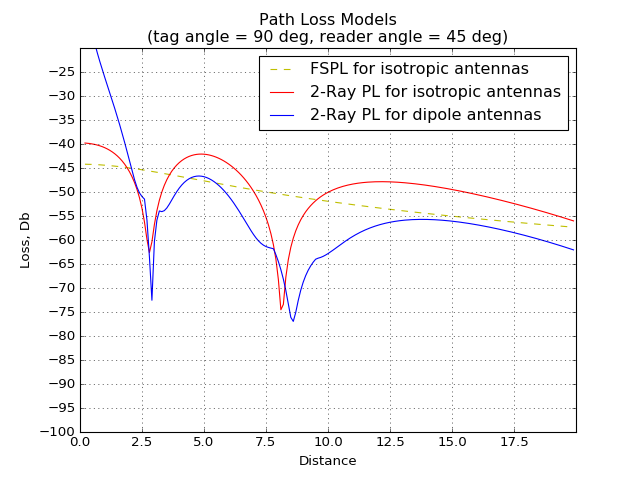

In [5]:
fig = figure(1)
ax = subplot(111)
plot(ox, w2db(PL1(ox, isotropic_reader, isotropic_tag, env)), 'y--', label='FSPL for isotropic antennas')
plot(ox, w2db(PL2(ox, isotropic_reader, isotropic_tag, env)), 'r', label='2-Ray PL for isotropic antennas')
plot(ox, w2db(PL2(ox, dipole_reader, dipole_tag, env)), 'b', label='2-Ray PL for dipole antennas')
grid(True)
ax.set_ybound(lower=-100, upper=-20)
ax.set_xticks(arange(0, 20, 2.5))
ax.set_yticks(arange(-100, -20, 5))
ax.set_xlabel("Distance")
ax.set_ylabel("Loss, Db")
ax.set_title('Path Loss Models\n(tag angle = 90 deg, reader angle = 45 deg)')
legend()

### Вычисление мощностей

Теперь нужно вычислить следующие мощности:

- мощность сигнала, принятого меткой
- мощность сигнала, отраженного меткой
- мощность сигнала, принятого считывателем

In [6]:
def RX_tag(distance, node_a, node_p, env, PL):
    return (node_a.tx_power + node_a.gain() + 
            w2db(PL(distance, node_a, node_p, env)) + 
            node_p.gain() + node_p.polarization_loss)

def TX_tag(distance, node_a, node_p, env, PL):
    return RX_tag(distance, node_a, node_p, env, PL) + node_p.modulation_loss

def RX_reader(distance, node_a, node_p, env, PL):
    return (TX_tag(distance, node_a, node_p, env, PL) + node_a.gain() +
            w2db(PL(distance, node_a, node_p, env)) + node_p.gain())

На следующих графиках приведены мощности приема метки и считывателя

<IPython.core.display.Javascript object>


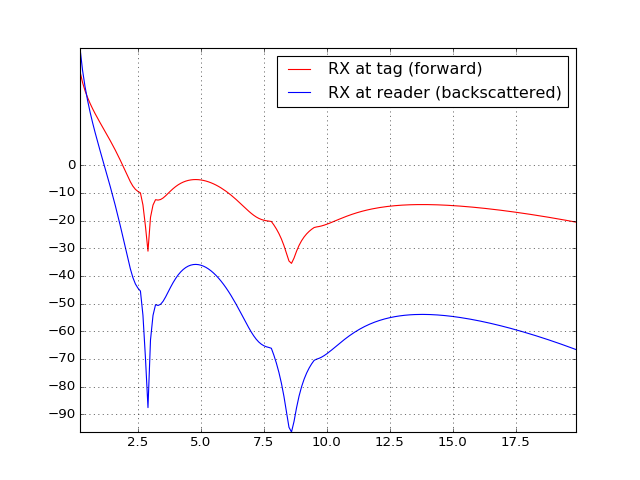

In [7]:
fig = figure(2)
ax = subplot(111)
ax.set_xticks(arange(0, 20, 2.5))
ax.set_yticks(arange(-150, 10, 10))
ax.set_ybound(lower=-150, upper=10)
plot(ox, RX_tag(ox, dipole_reader, dipole_tag, env, PL2), 'r', label='RX at tag (forward)')
plot(ox, RX_reader(ox, dipole_reader, dipole_tag, env, PL2), 'b', label='RX at reader (backscattered)')
grid(True)
legend()

### Вычисление BER



<IPython.core.display.Javascript object>


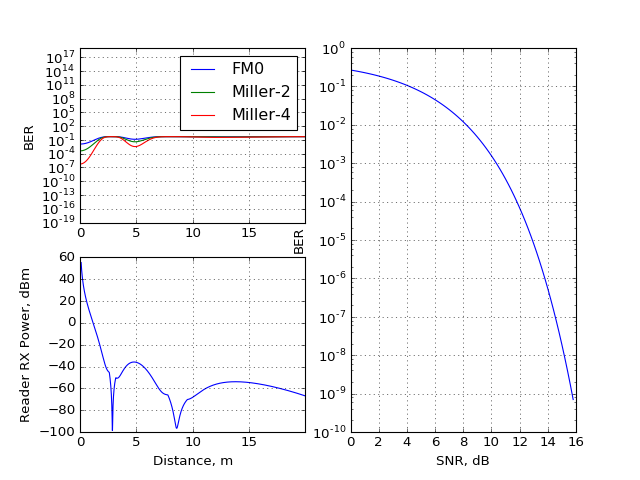

In [67]:
from scipy.special import erf

Q = lambda x: 0.5 - 0.5 * erf(x / np.sqrt(2))

def SNR(distance, node_a, node_p, env, PL):
    return dbm2w(RX_reader(distance, node_a, node_p, env, PL)) / dbm2w(env.noise)

def BER(snr, m, decibel_snr=False):
    if not decibel_snr:
        return 2*Q(sqrt(m*snr))*(1 - Q(sqrt(m*snr)))
    else:
        return 2*Q(sqrt(m*db2k(snr)))*(1 - Q(sqrt(m*db2k(snr))))

env.noise = -50

ox = arange(0.1, 20, 0.01)
fig = figure(3)
ax1 = subplot2grid((2,2), (0,0))
ax2 = subplot2grid((2,2), (1,0))
ax3 = subplot2grid((2,2), (0,1), rowspan=2)
ax1.plot(ox, BER(SNR(ox, isotropic_reader, isotropic_tag, env, PL2), m=1), label='FM0')
ax1.plot(ox, BER(SNR(ox, isotropic_reader, isotropic_tag, env, PL2), m=2), label='Miller-2')
ax1.plot(ox, BER(SNR(ox, isotropic_reader, isotropic_tag, env, PL2), m=4), label='Miller-4')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ybound(lower=10e-20, upper=10e18)
ax1.grid(True)
ax1.set_xticks(arange(0, 20, 5))
ax1.set_ylabel('BER')
ax2.plot(ox, RX_reader(ox, dipole_reader, dipole_tag, env, PL2))
ax2.grid(True)
ax2.set_xticks(arange(0, 20, 5))
ax2.set_ylabel('Reader RX Power, dBm')
ax2.set_xlabel('Distance, m')
_snr_axis = arange(0, 16, 0.2)
ax3.plot(_snr_axis, BER(_snr_axis, 1, True))
ax3.set_yscale('log')
ax3.grid(True)
ax3.set_ylabel('BER')
ax3.set_xlabel('SNR, dB')

## Моделирование протокола

Во-первых, нужно определить все те параметры протокола, которые влияют на скорость передачи данных и вероятность ошибки.

Работа считывателя характеризуется следующими параметрами:
- tari: длительность нулевого бита (data-0), $6.25\mu s \leq Tari \leq 25\mu s$
- data-1: длительность единичного бита, $1.5 \times Tari \leq data1 \leq 2.0 \times Tari$
- rtcal: Reader-Tag Calibration, длительность data0 + data1
- trcal: Tag-Reader Calibration, определяет скорость передачи данных меткой, $1.1 \times RTCal \leq TRCal \leq 3 \times RTCal$

Необходимо учесть то, что считыватель использует кодирование PIE (pulse-interval encoding). Из-за того, что в PIE биты кодируются импульсами разной длительности, сообщения, имеющие одинаковые битовые длины, могут иметь различную длительность -- все зависит от передаваемой информации, конкретного набора битов. Этот нюанс мы учтем ниже, когда будем рассчитывать длительность тактов.

Метка получает все данные, характеризующие скорость ее работы, от считывателя. Здесь же, для упрощения модели, будем считать, что метка с самого начала "все знает". Среди ее параметров выделим:
- m: схема кодирования, одна из FM0, Miller-2, Miller-4, Miller-8. Для нас принципиальным является только количество символов, используемых в кодировании одного бита, поэтому m будет равняться числу символов на бит (1, 2, 4 или 8 соответственно)
- trext: использует ли метка расширенную преамбулу.
- DR: делитель, равен либо 8, либо 64/3.
- длина EPC: будем считать, что EPC имеет длину 96 бит (как это было в эксперименте).

Также важнейшей характеристиккой метки является ее чувствительность -- уровень энергии, необходимый для того, чтобы запитать метку, и метка могла прочитать и передать свои данные (для записи может требоваться больше энергии, но это выходит за рамки нашего анализа).


In [9]:
def getbitstr(x, width=0):    
    s = ""
    if isinstance(x, int):        
        n_bits = 0
        while (x > 0 or n_bits == 0):
            s = ("0" if x % 2 == 0 else "1") + s
            x = x >> 1
            n_bits += 1
        if n_bits < width:
            s = '0' * (width - n_bits) + s
    elif isinstance(x, bool):
        s = "1" if x else "0"
        if width > 0:
            s = (width - 1) * '0' + s
    else:
        raise TypeError
    return s
        
        
class Protocol(object):
    def __init__(self, tari=6.25e-6, dr=8, 
                 rtcal_multiplier=2.0, 
                 trcal_multiplier=3.0,                  
                 trext=False, q=4, epcsize = 96, m=4,
                 trcal=None, rtcal=None):
        self.tari = tari
        self.dr = dr        
        self.rtcal_multiplier = rtcal_multiplier if rtcal is None else rtcal / self.tari
        self.trcal_multiplier = trcal_multiplier if trcal is None else trcal / self.rtcal
        self.m = m
        self.trext = trext
        self.q = q
        self.epcsize = epcsize
        
    @property
    def delim(self):
        return 12.5e-6
    
    @property
    def rtcal(self):
        return self.tari * self.rtcal_multiplier
    
    @property
    def trcal(self):
        return self.rtcal * self.trcal_multiplier
    
    @property
    def data0(self):
        return self.tari
    
    @property
    def data1(self):
        return self.rtcal - self.data0
    
    @property
    def BLF(self):
        return self.dr / self.trcal
    
    @property
    def bitrate(self):
        return self.BLF / self.m
    
    @property
    def tag_preamble_bitsize(self):
        if self.m == 1:
            return 6 if not self.trext else 18
        else:
            return 10 if not self.trext else 22
            
    @property
    def slots_num(self):
        return 2**self.q
        
    def is_response(self, msg):
        msg = msg.strip().lower()
        return msg == "rn16" or msg == "resp"
    
    def is_command(self, msg):
        msg = msg.strip().lower()
        return msg == "select" or msg == "query" or msg == "qrep" or msg == "ack"
            
    def get_response_bitsize(self, msg):
        msg = msg.strip().lower()
        if msg == "rn16":
            return 16
        elif msg == "resp":
            return 32 + self.epcsize
        else:
            raise RuntimeError("unrecognized response='{0}'".format(msg))
        
    def encode_command(self, msg):
        msg = msg.strip().lower()
        if msg == "query":
            return "D0RT1000{0}{1}{2}00000{3}11111".format(
                getbitstr(self.dr==64/3), getbitstr(self.m), 
                getbitstr(self.trext), getbitstr(self.q))
        elif msg == "qrep":
            return "D0R0000";
        elif msg == "ack":
            return "D0R011111111111111111"
        else:
            raise RuntimeError("unrecognized command='{0}'".format(msg))
        
    def get_duration(self, msg):
        msg = msg.strip().lower()
        if self.is_response(msg):
            return (self.get_response_bitsize(msg) + self.tag_preamble_bitsize + 1) / self.bitrate
        elif self.is_command(msg):
            n_data0 = 0
            n_data1 = 0
            n_delim = 0
            n_rtcal = 0
            n_trcal = 0
            encoded = self.encode_command(msg)
            for sym in encoded:
                if sym == "0":
                    n_data0 += 1
                elif sym == "1":
                    n_data1 += 1
                elif sym == "D":
                    n_delim += 1
                elif sym == "R":
                    n_rtcal += 1
                elif sym == "T":
                    n_trcal += 1
            return (n_data0 * self.data0 + n_data1 * self.data1 + 
                    n_delim * self.delim + n_rtcal * self.rtcal + 
                    n_trcal * self.trcal)
        else:
            raise RuntimeError("unrecognized message='{0}'".format(msg))


С помощью класса `Protocol`, описанного выше, рассчитаем длительности различных команд и ответов в зависимости от длительности `Tari`, `RTcal`, `TRcal`, `DR` и параметра `M`. Все времена в таблице приведены в микросекунд, а колонка `BLF` - в кГц.

In [10]:
import pandas as pd

def build_protocol_timing_table():
    values_m = [1,2,4,8]
    values_dr = [64/3, 8]
    values_tari = array([6.25, 12.5, 25.0]) * 1e-6
    values_trext = [False, True]
    values_rtcal_multipliers = [3.0]
    values_trcal_multipliers = [1.78, 3.0]
    q = 4
    
    data = dict(DR=[], Tari=[], RTcal=[], TRcal=[], M=[], Q=[], BLF=[],
               QUERY=[], QREP=[], ACK=[], RN16=[], RESP=[])
    for dr in values_dr:
        for tari in values_tari:
            for rtcal_multiplier in values_rtcal_multipliers:
                for trcal_multiplier in values_trcal_multipliers:
                    p = Protocol(dr=dr, tari=tari, q=q, 
                                 trcal_multiplier=trcal_multiplier, 
                                 rtcal_multiplier=rtcal_multiplier)
                    if p.trcal < 33.3*1e-9:
                        continue
                    for m in values_m:
                        p.m = m
                        data['DR'].append("8" if p.dr == 8 else "64/3")
                        data['Tari'].append(p.tari / 1e-6)
                        data['RTcal'].append(p.rtcal / 1e-6)
                        data['TRcal'].append(p.trcal / 1e-6)
                        data['M'].append(p.m)
                        data['Q'].append(p.q)
                        data['BLF'].append(p.BLF / 1e3)
                        data['QUERY'].append(p.get_duration("QUERY") / 1e-6)
                        data['QREP'].append(p.get_duration('QREP') / 1e-6)
                        data['ACK'].append(p.get_duration('ACK') / 1e-6)
                        data['RN16'].append(p.get_duration('RN16') / 1e-6)
                        data['RESP'].append(p.get_duration('RESP') / 1e-6)
#                     print("|RN16|={0}, |RESP|={1}".format(p.get_response_bitsize('RN16'), 
#                                                           p.get_response_bitsize('RESP')))
                    del p
    df = pd.DataFrame(data, columns=["DR", "Tari", "TRcal", "BLF", "M",
                                    'QUERY', 'QREP', 'ACK', 'RN16', 'RESP'])
    return df
        
timings = build_protocol_timing_table()
pd.set_option('precision', 2)
timings[timings.M.isin([1,8])]

,DR,Tari,TRcal,BLF,M,QUERY,QREP,ACK,RN16,RESP
0,64/3,6.25,33.38,639.20,1,252.13,62.5,256.25,35.98,211.20
3,64/3,6.25,33.38,639.20,8,270.88,62.5,256.25,337.92,1739.67
4,64/3,6.25,56.25,379.26,1,275.00,62.5,256.25,60.64,355.96
7,64/3,6.25,56.25,379.26,8,293.75,62.5,256.25,569.53,2932.03
8,64/3,12.50,66.75,319.60,1,491.75,112.5,500.00,71.96,422.40
11,64/3,12.50,66.75,319.60,8,529.25,112.5,500.00,675.84,3479.34
12,64/3,12.50,112.50,189.63,1,537.50,112.5,500.00,121.29,711.91
15,64/3,12.50,112.50,189.63,8,575.00,112.5,500.00,1139.06,5864.06
16,64/3,25.00,133.50,159.80,1,971.00,212.5,987.50,143.93,844.80
19,64/3,25.00,133.50,159.80,8,1046.00,212.5,987.50,1351.69,6958.69


Как видно из построенной таблицы, длительности передачи команд и ответов могут отличаться на порядок. Например, при `DR=64/3, Tari=6.25 мкс и TRcal=33.38 мкс` длительность передачи ответа метки составляет 211 мкс, а при `DR=8, Tari=25 мкс, TRcal=225 мкс` - уже болл 31 мс. Схожим образом обстоит дело и с длительность команд считывателя - так, длительность команды `QUERY` может меняться от 62.5 мкс до 212.5 мкс, `ACK` - от 256.25 мкс до 987.5 мкс.

Поскольку зона чтение невелика (до 20 м), и при этом требуется регистрировать метки, двигающиеся на скоростях до 180 км/ч (50 м/c), следует ограничить возможные значения параметров так, чтобы  передача ответа на занимала более 1 мс, в противном случае метка успеет принять участие в слишком малом числе раундов.

In [11]:
timings[timings.RESP <= 1000]

,DR,Tari,TRcal,BLF,M,QUERY,QREP,ACK,RN16,RESP
0,64/3,6.25,33.38,639.20,1,252.13,62.5,256.25,35.98,211.20
1,64/3,6.25,33.38,639.20,2,258.38,62.5,256.25,84.48,434.92
2,64/3,6.25,33.38,639.20,4,264.62,62.5,256.25,168.96,869.84
4,64/3,6.25,56.25,379.26,1,275.00,62.5,256.25,60.64,355.96
5,64/3,6.25,56.25,379.26,2,281.25,62.5,256.25,142.38,733.01
8,64/3,12.50,66.75,319.60,1,491.75,112.5,500.00,71.96,422.40
9,64/3,12.50,66.75,319.60,2,504.25,112.5,500.00,168.96,869.84
12,64/3,12.50,112.50,189.63,1,537.50,112.5,500.00,121.29,711.91
16,64/3,25.00,133.50,159.80,1,971.00,212.5,987.50,143.93,844.80
24,8,6.25,33.38,239.70,1,245.88,62.5,256.25,95.95,563.20


In [12]:
slowest_protocol = Protocol(dr=64/3, tari=25.0e-6, trcal=133.5e-6, rtcal_multiplier=3.0, m=1)
slower_protocol = Protocol(dr=64/3, tari=12.5e-6, trcal=112.5e-6, rtcal_multiplier=3.0, m=1)
normal_protocol = Protocol(dr=64/3, tari=12.5e-6, trcal=66.75e-6, rtcal_multiplier=3.0, m=1)
faster_protocol = Protocol(dr=64/3, tari=6.25e-9, trcal=56.25e-6, rtcal_multiplier=3.0, m=1)
fast_protocol = Protocol(dr=64/3, tari=6.25e-6, trcal=33.38e-6, rtcal_multiplier=3.0, m=1)
protocols = [slowest_protocol, normal_protocol, fast_protocol]

Проанализируем верятности ошибок при передаче ответов. Для этого построим кривые $P^{(err)}(x)$ для каждого сообщения от расстояния между считывателем и меткой. Всюда дальше мы будем использовать дипольные антенны на считывателе и метке.

<IPython.core.display.Javascript object>


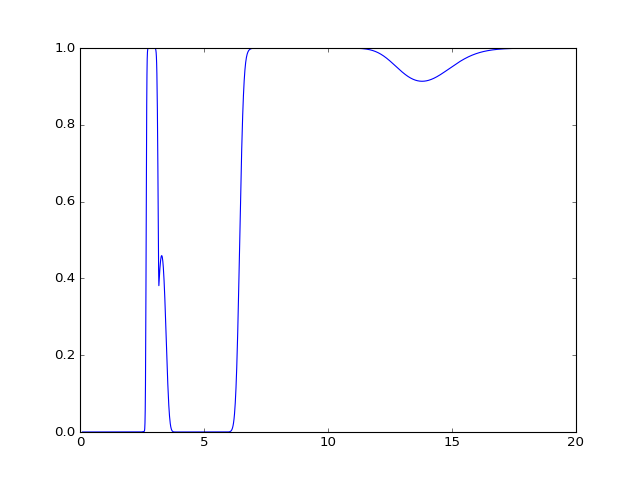

In [77]:
def response_lost_prob(resp, distance, protocol, node_a, node_p, env, PL, speed=16.6):
    bs = protocol.get_response_bitsize(resp)
    bt = 1./protocol.bitrate
    prob = 1
#     x = max(distance, 0.01)    
    x = distance
    
    snr = SNR(x, node_a, node_p, env, PL)
    ber = BER(snr, protocol.m)
    prob = 1 - pow((1 - ber), bs)
#     print("D={0:.2f}, SNR={1:.2f}, BER={2}, 1-BER={3}, prob={4}".format(distance, snr, ber, 1-ber, prob))    
#     for i in range(0, bs):        
#         snr = SNR(x, node_a, node_p, env, PL)
#         ber = BER(snr, protocol.m)
#         prob = prob * (1 - ber)
#         x = x - bt * speed
#     prob = 1 - prob
    return prob

env.noise = -57

fig = figure(4)
ax1 = subplot(111)
# ax1 = subplot2grid((3,2), (0,0))
# ax2 = subplot2grid((3,2), (1,0))
# ax3 = subplot2grid((3,2), (0,1))
# ax4 = subplot2grid((3,2), (1,1))
# ax5 = subplot2grid((3,2), (1,1))
# ax6 = subplot2grid((3,2), (1,1))
ax1.plot(ox, response_lost_prob('RN16', ox, normal_protocol, dipole_reader, dipole_tag, env, PL2))
fast_protocol.m = 2
# ax1.plot(ox, MLR('RESP', ox, normal_protocol, dipole_reader, dipole_tag, env, PL2))
# ax1.plot(ox, MLR('RESP', ox, faster_protocol, dipole_reader, dipole_tag, env, PL2))
# ax1.plot(ox, MLR('RESP', ox, fast_protocol, dipole_reader, dipole_tag, env, PL2))
# ax1.set_yscale('log')
# ax1.grid(True)
# ax1.set_xticks(arange(0, 20, 5))
# ax1.set_ylabel('BER')



In [53]:
i_s = 0
n_s = 0
protocol = normal_protocol
N_s = 2 ** normal_protocol.q
stop = False

T_QREP = protocol.get_duration('QREP')
T_ACK = protocol.get_duration('ACK')
T_RN16 = protocol.get_duration('RN16')
T_RESP = protocol.get_duration('RESP')
FrT = 0.15
T_pri = 1/protocol.BLF
T1 = max(protocol.rtcal, 10 * T_pri) * (1 + FrT) + 2e-6
T2 = 20 * T_pri
T3 = 0
T_empty_slot = T_QREP + T1 + T2
busy_prob = 0.0

# each item has the next structure:
#    (prob, x, n-reads)

speed = 16.6

def next_slot(items):
    if i_s % N_s == 0:
        n_s = randint(0, N_s) + i_s
    new_items = []
    found_any = False
    if i_s == n_s:
        for item in items:
            _t1 = T_QREP + T1
            _t2 = _t1 + T_RN16 + T2
            _t3 = _t2 + T_ACK + T1
            _t4 = _t3 + T_RESP + T2
            p0 = item[0]
            x0 = item[1]
            n0 = item[2]
            if x0 - speed * _t4 < 0:
                new_items.append(item)
                continue
            found_any = True
            x_RN16 = x0 - speed * _t1
            x_RESP = x0 - speed * _t3            
            rn16_lost_prob = response_lost_prob('RN16', x_RN16, protocol, dipole_reader, dipole_tag, env, PL2)
            resp_lost_prob = response_lost_prob('RESP', x_RN16, protocol, dipole_reader, dipole_tag, env, PL2)
            new_items.append((p0 * (busy_prob + (1 - busy_prob) * rn16_lost_prob),
                              x0 - speed * _t2,
                              n0))
            new_items.append((p0 * (1 - busy_prob) * (1 - rn16_lost_prob) * resp_lost_prob,
                              x0 - speed * _t4,
                              n0))
            new_items.append((p0 * (1 - busy_prob) * (1 - rn16_lost_prob) * (1 - resp_lost_prob),
                              x0 - speed * _t4,
                              n0 + 1))
    else:
        for item in items:
            p0 = item[0]
            x0 = item[1]
            n0 = item[2]
            if x0 < T_empty_slot * speed:
                new_items.append(item)
                continue
            found_any = True
            new_items.append((p0, x0 - T_empty_slot * speed, n0))
    if not found_any:
        stop = True
    return new_items

def filter_unprobable(items):
    new_items = []
    for item in items:
        if item[0] > 1e-10:
            new_items.append(item)
    return new_items

def filter_merge(items):
    new_items = []
    while len(items) > 0:
        item = items[0]
        p = item[0]
        for other in items:
            if item == other:
                continue
            if other[2] == item[2] and abs(other[1] - item[1]) < 0.5e-2:
                p += other[0]
                items.remove(other)
        items.remove(item)
        new_items.append((p, item[1], item[2]))        
    return new_items

item_0 = (1., 20, 0)
stop = False
items = [item_0]
iteration = 1
while not stop and iteration <= 240*N_s:
#     if iteration % N_s == 1:
#         print("iteration #{0}".format(iteration))
#         for item in items:
#             if item[2] > 0:
#                 print("\t{0}".format(item))
    iteration += 1
    items = filter_merge(filter_unprobable(next_slot(items)))
#     items = filter_merge(filter_unprobable(next_slot(items)))
print(items)
p = 0
for item in items:
    p += item[0]
print(p)

[(1.8231045775450756e-10, 5.470647557812995, 11), (4.9796098428750412e-09, 5.453547807031745, 11), (3.0223076406633112e-08, 5.453547807031745, 12), (2.5153705480257262e-10, 5.436448056250494, 10), (3.9216782476989435e-08, 5.436448056250494, 11), (5.7052384167275048e-07, 5.436448056250494, 12), (1.3779295799668722e-06, 5.436448056250494, 13), (9.2506190179239771e-10, 5.419348305469244, 10), (1.4984562299465179e-07, 5.419348305469244, 11), (4.103802770136546e-06, 5.419348305469244, 12), (2.3605652308974609e-05, 5.419348305469244, 13), (2.7435736038154369e-05, 5.419348305469244, 14), (1.0579111583763077e-09, 5.4022485546879935, 10), (3.1178890172371824e-07, 5.4022485546879935, 11), (1.4611984275524308e-05, 5.4022485546879935, 12), (0.00015222706880847262, 5.4022485546879935, 13), (0.00040450918856077761, 5.4022485546879935, 14), (0.00016461180286281743, 5.4022485546879935, 15), (7.684713880938049e-10, 5.385148803906743, 10), (3.6919056336728817e-07, 5.385148803906743, 11), (2.844971560772